In [17]:
!pip install--trusted-host pypi.org --trusted-host files.pythonhosted.org plotly

  Created wheel for retrying: filename=retrying-1.3.3-cp37-none-any.whl size=11435 sha256=1ec53c35b546a129b6695ff8dc16d5acca6494c3e70cd96b4f0989c0e014b7e4
  Stored in directory: C:\Users\LGCNS\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [3]:
import pandas as pd

code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌 
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format) 
# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다. 
code_df = code_df[['회사명', '종목코드']] 
# 한글로된 컬럼명을 영어로 바꿔준다. 
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'}) 

,name,code
0,DSR,155660
1,GS글로벌,001250
2,HSD엔진,082740
3,LG이노텍,011070
4,LS산전,010120
...,...,...
2350,에이원알폼,234070
2351,원바이오젠,278380
2352,지앤이헬스케어,299480
2353,코셋,189350


In [9]:
code_df.loc[ (code_df['name']=='삼성전자') | (code_df['name']=='LG전자') | (code_df['name']=='LG화학') | (code_df['name']=='LG생활건강') | (code_df['name']=='LG디스플레이')]

,name,code
297,LG디스플레이,034220
905,LG화학,051910
943,삼성전자,005930
1497,LG전자,066570
1786,LG생활건강,051900


In [294]:
# 종목 이름을 입력하면 종목에 해당하는 코드를 불러와
# 네이버 금융(http://finance.naver.com)에 넣어줌
def get_url(item_name, code_df): 
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False).strip()
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code) 
    print("요청 URL = {}".format(url)) 
    return url 

# 삼성전자의 일자데이터 url 가져오기 
item_name='LG디스플레이' 
url = get_url(item_name, code_df) 

# 일자 데이터를 담을 df라는 DataFrame 정의 
df = pd.DataFrame() 

# 현재 ~ 2017.01 데이터만 가져오기 
for page in range(1, 78): 
    pg_url = '{url}&page={page}'.format(url=url, page=page) 
    df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
    
# df.dropna()를 이용해 결측값 있는 행 제거 
df = df.dropna()

요청 URL = http://finance.naver.com/item/sise_day.nhn?code=034220


In [295]:
df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 
# 데이터의 타입을 int형으로 바꿔줌 
df[['close', 'diff', 'open', 'high', 'low', 'volume']] \
    = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int)
# 컬럼명 'date'의 타입을 date로 바꿔줌 
df['date'] = pd.to_datetime(df['date']) 
# 일자(date)를 기준으로 오름차순 정렬 
df = df.sort_values(by=['date'], ascending=True)

In [296]:
# 필요한 모듈 import 하기
import plotly.offline as offline 
import plotly.graph_objs as go 

# jupyter notebook 에서 출력 
offline.init_notebook_mode(connected=True)

trace = go.Scatter(
                x=df.date,
                y=df.close,
                name=item_name)

data = [trace]

# data = [celltrion]
layout = dict(
            title='{}의 종가(close) Time Series'.format(item_name),
            xaxis=dict(
                rangeselector=dict(
                    buttons=list([
                        dict(count=1,
                             label='1m',
                             step='month',
                             stepmode='backward'),
                        dict(count=3,
                             label='3m',
                             step='month',
                             stepmode='backward'),
                        dict(count=6,
                             label='6m',
                             step='month',
                             stepmode='backward'),
                        dict(step='all')
                    ])
                ),
                rangeslider=dict(),
                type='date'
            )
        )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)

In [341]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
dt = pd.DatetimeIndex(df['date'])
dt = dt.to_period(freq='D')
df_close = pd.DataFrame(df.close, columns=['close'])
df_close = df_close.set_index(dt)
#df_close = df[['date','close']]
#df_close.set_index('date', inplace=True)
#df_close.head()
df_close.head()

,close
date,
2016-12-21,31500
2016-12-22,31400
2016-12-23,31300
2016-12-26,32000
2016-12-27,31400


In [346]:
len(df_close)

770

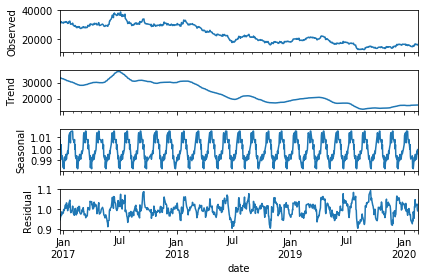

In [347]:
# 시계열 분해
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

result = seasonal_decompose(df_close, model='multiplicative', freq = 30, extrapolate_trend='freq' )
result.plot()
plt.show()

In [348]:
df_trend = df_close
df_trend['trend'] = result.trend
df_trend['seasonal'] = result.seasonal
df_trend['resid'] = result.resid
df_trend['d_formed'] = df_close['close'] - df_trend['trend'] - df_trend['seasonal']
df_trend

,close,trend,seasonal,resid,d_formed
date,,,,,
2016-12-21,31500,33118.606847,1.005446,0.945975,-1619.612293
2016-12-22,31400,33006.835805,1.008139,0.943638,-1607.843944
2016-12-23,31300,32895.064763,0.999887,0.951618,-1596.064651
2016-12-26,32000,32783.293721,1.003686,0.972522,-784.297408
2016-12-27,31400,32671.522680,0.993562,0.967309,-1272.516242
...,...,...,...,...,...
2020-02-10,16150,15968.449450,0.991061,1.020492,180.559489
2020-02-11,16150,15979.534545,0.993518,1.017261,169.471937
2020-02-12,16350,15990.619639,0.998218,1.024300,358.382143


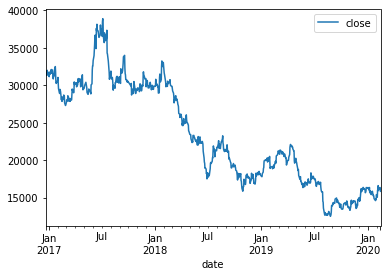

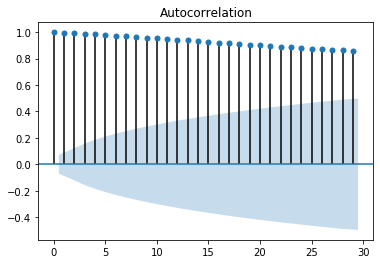

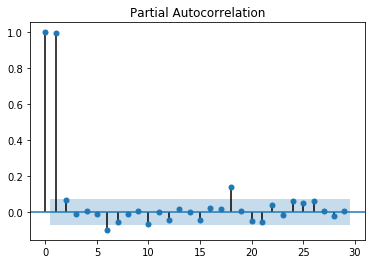

In [328]:
df_close.plot()
plot_acf(df_close)
plot_pacf(df_close)
plt.show()

In [219]:
len(df_close)

520

In [58]:
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org pmdarima

In [134]:
import pmdarima as pm
from pmdarima.arima import ARIMA
from pmdarima.utils import tsdisplay
from sklearn.model_selection import train_test_split

In [329]:
y_train, y_test = train_test_split(df_close, train_size=int(len(df_close)*0.8))

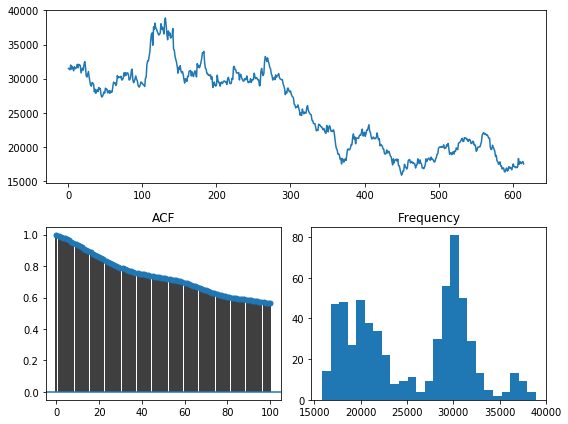

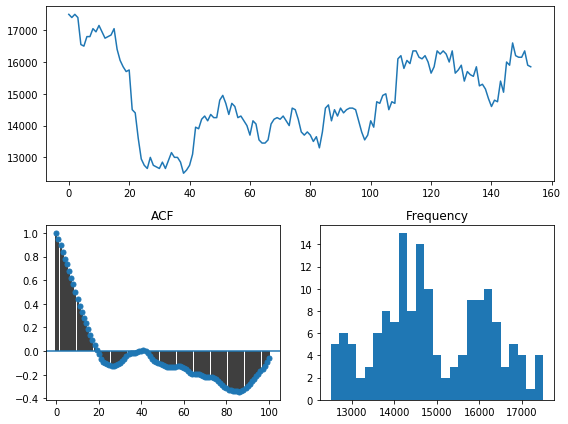

In [322]:
tsdisplay(y_train, lag_max=100)
tsdisplay(y_test, lag_max=100)

In [323]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [324]:
#fit1 = pm.auto_arima(y_train, trace=True, suppress_warnings=True, error_action="ignore")
fit1 = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)
fit1.summary()

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 0); AIC=9493.114, BIC=9519.644, Fit time=0.410 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=9488.618, BIC=9497.461, Fit time=0.023 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=9487.378, BIC=9500.643, Fit time=0.053 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=9487.491, BIC=9500.756, Fit time=0.072 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=9487.709, BIC=9492.131, Fit time=0.012 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=9489.249, BIC=9506.935, Fit time=0.087 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=9489.172, BIC=9506.858, Fit time=0.167 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=9491.156, BIC=9513.264, Fit time=0.488 seconds
Total fit time: 1.318 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  616
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -4740.689
Date:                Fri, 14 Feb 2020   AIC                           9487.378
Time:                        15:32:02   BIC                           9500.643
Sample:                             0   HQIC                          9492.536
                                - 616                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -24.3965     21.922     -1.113      0.266     -67.362      18.569
ar.L1         -0.0640      0.034     -1.893      0.058      -0.130       0.002
sigma2      2.906e+05   1.11e+04     26.236      0.000    2.69e+05    3.12e+05
===================================================================================
Ljung-Box (Q):                       56.55   Jarque-Bera (JB):               282.87
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [318]:
print(fit1.order)

(1, 0, 0)


In [319]:
from pmdarima.preprocessing import LogEndogTransformer

y_train_log, _ = LogEndogTransformer(lmbda=1e-6).fit_transform(y_train)
tsdisplay(y_train_log, lag_max=100)

ValueError: Negative or zero values present in y

In [320]:
from pmdarima.preprocessing import BoxCoxEndogTransformer

y_train_bc, _ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(y_train)
tsdisplay(y_train_bc, lag_max=100)

ValueError: Data must be positive.

In [290]:
from scipy.stats import normaltest
normaltest(y_train_bc)
# y_train : 1.19246676e-08
# y_train_log : 0.11872570838730746
# y_train_bc : 0.9564618841509848

NormaltestResult(statistic=0.08902868037821249, pvalue=0.9564618841509848)

In [315]:
#y_test_bc, _ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(y_test)
#tsdisplay(y_test_bc)
test_data = y_test_bc
forecasts = fit1.predict(n_periods=y_test.shape[0])

In [311]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = fit1  # seeded from the model we've already fit

def forecast_one_step(m):
    fc, conf_int = m.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forec = []
confidence_intervals = []

for new_ob in y_test['close']:
    fc, conf = forecast_one_step(model)
    forec.append(fc)
    confidence_intervals.append(conf)
        
    # Updates the existing model with a small number of MLE steps
    # model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(y_test, forec)}")
print(f"SMAPE: {smape(y_test, forec)}")
# Mean squared error: 0.3416473178248818
# SMAPE: 0.981464018635346

Mean squared error: 119511.68837388184
SMAPE: 196.4674919367541


In [316]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(y_test.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(y_test.index, y_test, color='red', label='Actual Price')
axes[0].set_title('LGD Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['date'][0:7982:1300].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['date'][0:7982:1300].tolist())
axes[1].legend()

AttributeError: 'numpy.ndarray' object has no attribute 'index'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000136D8C98708> (for post_execute):


ValueError: view limit minimum 0.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum 0.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [267]:
from sklearn.metrics import mean_squared_error as mse


def plot_forecasts(forecasts, title, figsize=(8, 12)):
    x = np.arange(y_train.shape[0] + forecasts.shape[0])

    fig, axes = plt.subplots(2, 1, sharex=False, figsize=figsize)

    # Plot the forecasts
    axes[0].plot(x[:y_train.shape[0]], y_train, c='b')
    axes[0].plot(x[y_train.shape[0]:], y_test, c='b')
    axes[0].plot(x[y_train.shape[0]:], forecasts, c='g')
    axes[0].set_xlabel(f'Sunspots (RMSE={np.sqrt(mse(y_test, forecasts)):.3f})')
    axes[0].set_title(title)

    # Plot the residuals
    resid = y_test - forecasts
    _, p = normaltest(resid)
    p = p[0]
    axes[1].hist(resid, bins=15)
    axes[1].axvline(0, linestyle='--', c='r')
    axes[1].set_title(f'Residuals (p={p:.3f})')

    plt.tight_layout()
    plt.show()

In [271]:
pred = y_test
pred['close'] = forec

C:\Users\LGCNS\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



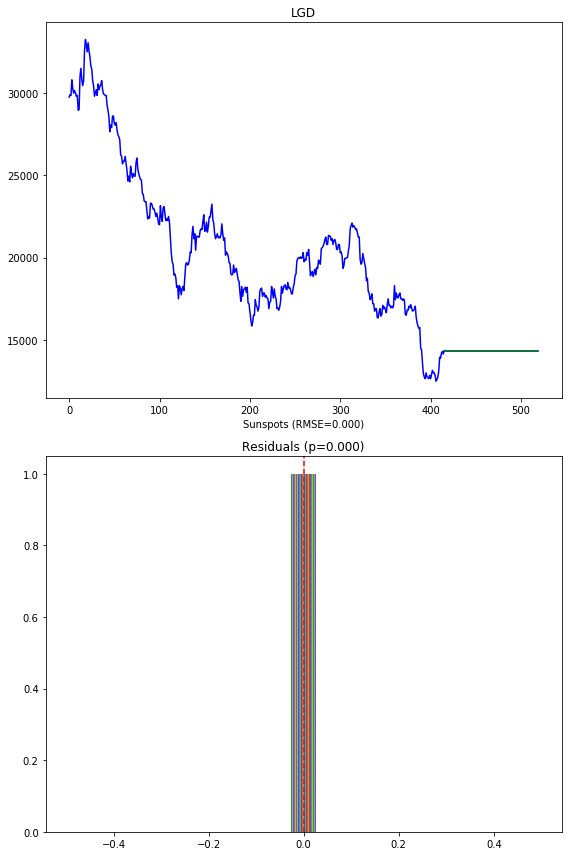

In [272]:
plot_forecasts(pred, 'LGD')